<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#v1-style" data-toc-modified-id="v1-style-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>v1 style</a></span></li><li><span><a href="#v2-style" data-toc-modified-id="v2-style-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>v2 style</a></span></li></ul></li><li><span><a href="#Arch" data-toc-modified-id="Arch-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Arch</a></span><ul class="toc-item"><li><span><a href="#Anchors" data-toc-modified-id="Anchors-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Anchors</a></span></li><li><span><a href="#Layers" data-toc-modified-id="Layers-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Layers</a></span></li><li><span><a href="#Loss-Functions" data-toc-modified-id="Loss-Functions-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Loss Functions</a></span></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Stepping-through-a-batch" data-toc-modified-id="Stepping-through-a-batch-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Stepping through a batch</a></span></li></ul></div>

In [ ]:
from fastai.vision.all import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
from ipywidgets import FloatProgress
from IPython.display import display
import time

In [ ]:
### RM Utils ###

def random_seed(s, use_cuda):
    #Also, remember to use num_workers=0 when creating the DataBunch
    np.random.seed(s)
    torch.manual_seed(s)
    random.seed(s)
    if use_cuda:
        torch.cuda.manual_seed(s)
        torch.cuda.manual_seed_all(s)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False      
random_seed(42,True)

def dict2list(d):
    return [(k,v) for k,v in list(d.items())]

# Data

## v1 style

In [ ]:
path = untar_data(URLs.PASCAL_2007)
annos_path = path/'train.json'
ims_path = path/'train'

In [ ]:
trn_json = json.load(annos_path.open())                        # {'images':[img data], ...
cats = {o['id']:o['name'] for o in trn_json['categories']}     # {1: 'aeroplane', ...
imgs_fn = {o['id']:o['file_name'] for o in trn_json['images']} # {12:'000012.jpg', 17: ...
imgs_id = [o['id'] for o in trn_json['images']]                # [12, 17, 23, ...

In [ ]:
trn_anno = collections.defaultdict(lambda:[])                  # {12: [(bb,clsid)], ...
for annot in trn_json['annotations']:
    if annot['ignore'] == 0:
        bb = annot['bbox']
        #Transforms bb which is left,top, width, height into top, left, bottom, right.
        bb = [bb[1],bb[0],bb[1] + bb[3], bb[0]+bb[2]]
        trn_anno[annot[('image_id')]].append((bb, annot['category_id']))

In [ ]:
f_model       = resnet34
size=im_sz    = 224
batch_size=bs = 64

In [ ]:
annot_cats = [[cats[int(ann[1])] for ann in trn_anno[i]] for i in imgs_id]
id2cats = list(cats.values())
cats2id = {c:i for i,c in enumerate(id2cats)}
model_cats = np.array([np.array([cats2id[c] for c in ac]) for ac in annot_cats],
                      dtype=object)
model_cats[0:3] # obj classes per im; encoded from [0,19]

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14])],
      dtype=object)

In [ ]:
model_bbs  = [np.concatenate([ann[0] for ann in trn_anno[i]]) for i in imgs_id]
model_bbsc = [' '.join([str(p) for p in o]) for o in model_bbs]
model_bbsc[0:3] # bb coords per im

['96 155 270 351',
 '61 184 199 279 77 89 336 403',
 '229 8 500 245 219 229 500 334 0 1 369 117 1 2 462 243 0 224 486 334']

**dls**

In [ ]:
fns    = [imgs_fn[k] for k in imgs_fn]
labels = [(list(b),list(c)) for b,c in zip(model_bbs,model_cats)]

fn2label = {k:v for k,v in zip(fns,labels)}
fn2label[fns[0]]

([96, 155, 270, 351], [6])

In [ ]:
def get_path(f): return ims_path/f
def get_bb(f):   return fn2label[f][0]
def get_cls(f):  return fn2label[f][1]

i=0; get_path(fns[i]), get_bb(fns[i]), get_cls(fns[i])

(Path('/home/rory/.fastai/data/pascal_2007/train/000012.jpg'),
 [96, 155, 270, 351],
 [6])

In [ ]:
fn_tfms  = [get_path, PILImage.create]
bb_tfms  = [get_bb, TensorBBox.create]
cls_tfms = [get_cls, MultiCategorize(add_na=False)]
dss = Datasets(fns, [fn_tfms, bb_tfms, cls_tfms], splits=RandomSplitter()(fns), n_inp=1)

item_tfms = [BBoxLabeler(), PointScaler(), Resize(size,'squish'), ToTensor()]
aug_tfms  = setup_aug_tfms([IntToFloatTensor(), Rotate(), Brightness(), Contrast(), Flip()])
dls = dss.dataloaders(bs=bs, after_item=item_tfms, before_batch=bb_pad, after_batch=aug_tfms)

b=next(iter(dls.train)); b[0][0], b[1][0], b[2][0]

(tensor([[[0.4096, 0.4096, 0.4058,  ..., 0.2923, 0.2923, 0.2961],
          [0.4507, 0.4133, 0.4283,  ..., 0.2961, 0.3000, 0.3000],
          [0.4544, 0.4208, 0.3795,  ..., 0.3038, 0.3076, 0.3076],
          ...,
          [0.5585, 0.5660, 0.5697,  ..., 0.6180, 0.6143, 0.6106],
          [0.5771, 0.5734, 0.5697,  ..., 0.6367, 0.6292, 0.6255],
          [0.5697, 0.5734, 0.5697,  ..., 0.6553, 0.6479, 0.6367]],
 
         [[0.3304, 0.3304, 0.4358,  ..., 0.4656, 0.4693, 0.4730],
          [0.3266, 0.4021, 0.5437,  ..., 0.4730, 0.4768, 0.4768],
          [0.3456, 0.5251, 0.6069,  ..., 0.4768, 0.4842, 0.4842],
          ...,
          [0.5846, 0.5920, 0.5957,  ..., 0.6255, 0.6255, 0.6255],
          [0.5957, 0.5920, 0.5920,  ..., 0.6404, 0.6441, 0.6404],
          [0.5846, 0.5920, 0.5883,  ..., 0.6591, 0.6591, 0.6516]],
 
         [[0.1913, 0.4171, 0.7913,  ..., 0.7837, 0.7799, 0.7760],
          [0.2885, 0.5808, 0.8811,  ..., 0.7875, 0.7837, 0.7760],
          [0.4842, 0.7837, 0.9174,  ...,

In [ ]:
len(dls.train)

31

In [ ]:
dls.vocab = L(id2cats)
dls.ncls = len(dls.vocab)

## v2 style

In [ ]:
### Imports & Paths ###
from fastai.vision.all import *
import pandas as pd

def random_seed(s, use_cuda):
    #Also, remember to use num_workers=0 when creating the DataBunch
    np.random.seed(s)
    torch.manual_seed(s)
    random.seed(s)
    if use_cuda:
        torch.cuda.manual_seed(s)
        torch.cuda.manual_seed_all(s)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False      
random_seed(42,True)


### Params ###
im_sz   = 224
bs      = 64
val_pct = .2
sub_pct = 1
path = untar_data(URLs.PASCAL_2007)
annos_path = path/'train.json'
ims_path = path/'train'


### Items ###
fns, annos = get_annotations(annos_path)
fn2anno = {f:a for f,a in zip(fns,annos)}
def get_im(f):   return ims_path/f
def get_bbox(f): return fn2anno[f][0]
def get_lbl(f):  return fn2anno[f][1]
def get_both(f): return (get_bbox(f), get_lbl(f))


### DataLoaders ###
itfms = Resize(im_sz, method='squish')
btfms = setup_aug_tfms([Rotate(), Brightness(), Contrast(), Flip(),
                       Normalize.from_stats(*imagenet_stats)])
db = DataBlock(
    blocks=[ImageBlock, BBoxBlock, BBoxLblBlock(add_na=False)],
    get_x=get_im,
    get_y=[get_bbox, get_lbl],
    splitter=RandomSplitter(val_pct),
    item_tfms=itfms,
    batch_tfms=btfms,
    n_inp=1)
dls = db.dataloaders(fns, bs=bs)
# subset = L(fns).shuffle()[0:int(len(fns)*sub_pct)]
# dls = db.dataloaders(subset, bs=bs)
dls.v = dls.vocab
dls.ncls = len(dls.vocab)

# Arch

## Anchors

In [ ]:
### Anchors ###
from numpy import array as arr, concatenate as cat, tile, repeat, stack, linspace

divs = [4,2,1]
zooms = [0.75, 1., 1.3]
aspects = [(1.,1.), (1.,0.5), (0.5,1.)]
perms = [(zm*x,zm*y) for zm in zooms for (x,y) in aspects]
spacing = [1/(o*2) for o in divs]
k = len(perms) # k == number of permutations per box

xs   = cat([  tile(linspace(s,1-s,d),d) for s,d in zip(spacing,divs)])
ys   = cat([repeat(linspace(s,1-s,d),d) for s,d in zip(spacing,divs)])
ctrs = repeat(stack([xs,ys], axis=1), k, axis=0)
anc_sizes = cat([arr([[w/d,h/d] for i in range(d*d) for w,h in perms]) for d in divs])
grid_sizes = tensor(cat([arr([1/d for i in range(d*d) for p in perms]) for d in divs]),
                    requires_grad=False).unsqueeze(1)
anchors = tensor(cat([ctrs, anc_sizes], axis=1), requires_grad=False).float()

def hw2corners(ctr, hw): return torch.cat([ctr-hw/2,ctr+hw/2], dim=1)
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

## Layers

In [ ]:
### Architecture ###
class StdConv(nn.Module):
    def __init__(self, n_in, n_out, stride=2, dp=0.1):
        super().__init__()
        self.conv = nn.Conv2d(n_in,n_out,3,stride=stride,padding=1)
        self.bn = nn.BatchNorm2d(n_out)
        self.dropout = nn.Dropout(dp)
        
    def forward(self,x):
        return self.dropout(self.bn(F.relu(self.conv(x))))
    
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

class OutConv(nn.Module):
    def __init__(self, k, n_in, bias):
        super().__init__()
        self.k = k
        self.bbs  = nn.Conv2d(n_in,            4*k, 3, padding=1)
        self.lbls = nn.Conv2d(n_in, (dls.ncls+1)*k, 3, padding=1)
        self.lbls.bias.data.zero_().add_(bias)
        
    def forward(self,x):
        return [flatten_conv(self.bbs(x),  self.k),
                flatten_conv(self.lbls(x), self.k)]
    
class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias=-4., drop=0.4):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv1 = StdConv(512,256, dp=drop)
        self.sconv2 = StdConv(256,256, dp=drop)
        self.sconv3 = StdConv(256,256, dp=drop)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv1(x)
        bbs1,lbls1 = self.out1(x)
        x = self.sconv2(x)
        bbs2,lbls2 = self.out2(x)
        x = self.sconv3(x)
        bbs3,lbls3 = self.out3(x)
        return [torch.cat([ bbs1, bbs2, bbs3], dim=1),
                torch.cat([lbls1,lbls2,lbls3], dim=1)]
    
class CustMod(Module):
    def __init__(self, body, head):
        self.body, self.head = body, head
        
    def forward(self, x):
        return self.head(self.body(x))

## Loss Functions

In [ ]:
### FocalLoss ###
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data].to(device)

class BCE_Loss(nn.Module):
    def __init__(self, num_classes, device):
        super().__init__()
        self.num_classes, self.device = num_classes, device
    
    def forward(self, preds, targets):
        t = one_hot_embedding(targets, self.num_classes+1)
        t = tensor(t[:,:-1].contiguous())
        x = preds[:,:-1]
        w = self.get_weight(x,t).detach()
        return F.binary_cross_entropy_with_logits(x,t,w,reduction='sum') / self.num_classes
    
    def get_weight(self,x,t):
        return None

class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,2.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

    
### IoU ###
def intersection(box_a,box_b):
    min_xy = torch.max(box_a[:,None,:2],box_b[None,:,:2])
    max_xy = torch.min(box_a[:,None,2:],box_b[None,:,2:])
    inter = torch.clamp(max_xy-min_xy,min=0)
    return inter[:,:,0] * inter[:,:,1]
def get_size(box):
    return (box[:,2]-box[:,0]) * (box[:,3] - box[:,1])
def jaccard(box_a,box_b):
    inter = intersection(box_a,box_b)
    union = get_size(box_a).unsqueeze(1) + get_size(box_b).unsqueeze(0) - inter
    return inter/union


### ssd_loss ###
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)
    bb_keep = ((bbox[:,2] - bbox[:,0])>0.).nonzero()[:,0]
    return bbox[bb_keep], clas[bb_keep]
    
def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_ctrs = (actn_bbs.cuda()[:,:2] * grid_sizes.cuda()/2) + anchors.cuda()[:,:2]
    actn_hw = (1 + actn_bbs.cuda()[:,2:]/2) * anchors.cuda()[:,2:]
    return hw2corners(actn_ctrs,actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_bb, b_c, bbox, clas, print_it=False, use_ab=True):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, (anchor_cnr.cuda() if use_ab else a_ic).data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[~pos] = dls.ncls
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(acts, bbs, lbls, print_it=False):
    bb_sum, lbl_sum = 0., 0.
    for abb, albl, bb, lbl in zip(*acts, bbs, lbls):
        bb_loss, lbl_loss = ssd_1_loss(abb, albl, bb, lbl, print_it)
        bb_sum += bb_loss
        lbl_sum += lbl_loss
    met.bb.append(bb_sum)
    met.lbl.append(lbl_sum)
    return bb_sum + lbl_sum

In [ ]:
class ShowLosses(Metric):
    
    def __init__(self): self.bb,self.lbl = [],[]
        
    def reset(self):    self.bb,self.lbl = [],[] 
        
    def accumulate(self, learn): pass
    
    @property
    def value(self):
        bb_loss  = round((sum(self.bb )/len(self.bb )).item(), 2)
        lbl_loss = round((sum(self.lbl)/len(self.lbl)).item(), 2)
        return bb_loss, lbl_loss
    
    @property
    def name(self): return "MAE, Focal"

# Train

In [ ]:
device='cuda'
body = create_body(resnet34, pretrained=True)
head = SSD_MultiHead(k, -4.)
mod = CustMod(body, head)
loss_f = FocalLoss(dls.ncls, device)
met = ShowLosses()

In [ ]:
learner = Learner(dls, mod, loss_func=ssd_loss, metrics=met)
learner.freeze()
# learner.lr_find()

In [ ]:
# learner.fit_one_cycle(8, lr=1e-3)

epoch,train_loss,valid_loss,"MAE, Focal",time
0,38.176125,40.924175,"(25.8, 15.05)",00:13
1,33.642242,29.388613,"(19.53, 9.78)",00:15
2,31.306536,30.799395,"(20.8, 9.94)",00:12
3,29.876642,32.802368,"(23.43, 9.25)",00:12
4,28.831141,26.362925,"(18.94, 7.34)",00:12
5,28.000237,26.951889,"(18.67, 8.2)",00:12
6,27.271841,25.895023,"(18.65, 7.15)",00:12
7,26.539713,25.380730,"(18.31, 6.99)",00:12


In [ ]:
# learner.export('models/20201218_object_det_nb_conversion.pkl')

# Stepping through a batch

In [ ]:
batch = next(iter(dls.train))
acts = mod(batch[0])
bbs, lbls = batch[1], batch[2]

In [ ]:
[t.shape for t in acts]

[torch.Size([32, 189, 4]), torch.Size([32, 189, 21])]

In [ ]:
for abb, albl, bb, lbl in zip(*acts, bbs, lbls):
    print(abb, albl, bb, lbl)
    break

tensor([[-6.8240e-01,  8.8219e-01, -1.4185e-01, -2.3007e-01],
        [-1.2655e-02,  7.6450e-01,  2.7903e-02, -3.8718e-01],
        [-6.4121e-01, -6.9655e-01,  1.8215e-01,  5.4302e-01],
        [-2.7926e-01,  5.9302e-01, -2.2809e-01, -7.0039e-02],
        [-7.4155e-02,  2.4040e-03,  2.0239e-01, -4.7266e-01],
        [-5.0507e-01,  9.6168e-02, -3.3744e-01,  2.5188e-01],
        [-5.0722e-01, -9.5825e-02, -2.9593e-02, -2.9554e-01],
        [ 2.0470e-01, -4.5720e-02, -2.0977e-01, -9.9086e-01],
        [-3.9952e-01,  6.7212e-02,  6.4349e-01, -9.3568e-01],
        [-4.9669e-01,  5.9573e-01, -1.0969e+00,  2.8203e-02],
        [ 1.7540e-01, -2.7322e-01,  3.8311e-01, -1.6349e-01],
        [-1.7120e+00, -3.8405e-01, -3.5705e-01,  3.7406e-01],
        [ 1.7404e-01, -7.5092e-02, -1.0668e+00, -3.0026e-01],
        [ 4.7586e-01,  4.8957e-01, -5.1402e-02, -1.1554e+00],
        [-1.1033e+00,  1.8234e+00, -1.1935e-01, -1.2620e-02],
        [-5.5104e-01, -1.1290e+00, -1.7175e+00, -9.7550e-01],
        

<AxesSubplot:>

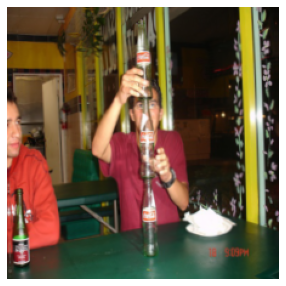

In [ ]:
show_image(batch[0][0])